In [1]:
from aqua import Reader,catalogue, inspect_catalogue
import sys
sys.path.append("../")
import ocean_circulation_func as fn

FDB5 binary library not present on system, disabling FDB support.


In [2]:
# Here we load the EN4 observations
reader = Reader(model='EN4',exp='en4',source='monthly')
den4=reader.retrieve()
den4=den4.rename({"depth":"lev"}) # To standardise the name for the vertical dimension
den4=den4[["ocpt","so"]]
den4_yearly=den4.resample(time="Y").mean()
den4_monthly=den4.resample(time="M").mean()

In [3]:
# Here we load the data of a model (chosen from the catalog as an example )
reader = Reader(model='FESOM', exp='tco2559-ng5-cycle3', source="lra-r100-monthly")
dmod = reader.retrieve()

dmod=dmod.rename({"nz1":"lev"}) # To standardise the name for the vertical dimension
dmod=dmod[["ocpt","so"]]

dmod_yearly=dmod.resample(time="Y").mean() # We compute 
dmod_monthly=dmod.resample(time="M").mean()

In [4]:
# Here we compute the regional average of temperature and salinity in the Labrador Sea region (other regions can be selected/defined) 
dmod_yearly_ls_mean=fn.weighted_area_mean(dmod_yearly,50, 65, 300, 325) # In the model (yearly)
den4_yearly_ls_mean=fn.weighted_area_mean(den4_yearly,50, 65, 300, 325) # In the obs (yearly)
dmod_monthly_ls_mean=fn.weighted_area_mean(dmod_monthly,50, 65, 300, 325) # In the model (monthly)
den4_monthly_ls_mean=fn.weighted_area_mean(den4_monthly,50, 65, 300, 325) # In the obs (monthly)

In [5]:
# Here we compute the density values (referred to the surface level, sigma0)
rho_t_s_labrador_mod_yl= fn.convert_variables(dmod_yearly_ls_mean) # In the model (yearly)
rho_t_s_labrador_en4_yl= fn.convert_variables(den4_yearly_ls_mean) # In the obs (yearly)
rho_t_s_labrador_mod_ml= fn.convert_variables(dmod_monthly_ls_mean) # In the model (monthly)
rho_t_s_labrador_en4_ml= fn.convert_variables(den4_monthly_ls_mean) # In the obs (monthly)

In [21]:
#fn.plot_strat_obs_1mod(converted_labrador_sea_mean, "Labrador Sea")

<xarray.Dataset>
Dimensions:  (lev: 42, time: 73)
Coordinates:
  * lev      (lev) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03
  * time     (time) datetime64[ns] 1950-12-31 1951-12-31 ... 2022-12-31
Data variables:
    so       (time, lev) float64 dask.array<chunksize=(1, 42), meta=np.ndarray>
    ocpt     (time, lev) float64 dask.array<chunksize=(1, 42), meta=np.ndarray>
    rho      (time, lev) float64 dask.array<chunksize=(1, 42), meta=np.ndarray>

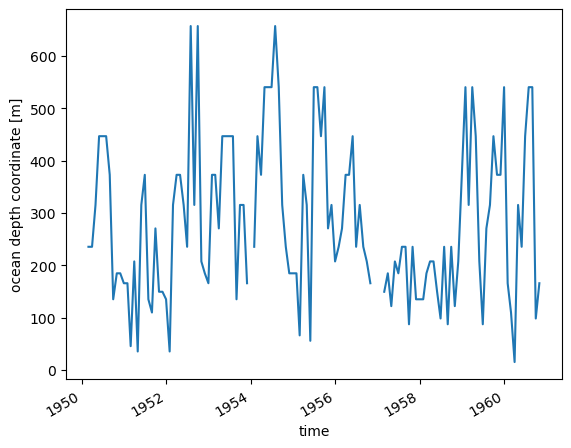

In [6]:
mld_en4=fn.compute_mld(rho_t_s_labrador_en4_ml.rho[0:130,])
mld_mod=fn.compute_mld(rho_t_s_labrador_mod_ml.rho)
mld_en4
mld_en4.plot()


[1027.4166081  1027.39099304 1027.54328938 1027.52253932 1027.36377259
 1027.01794039 1026.48017276 1026.28438627 1026.20190842 1026.4283589
 1026.68495515 1026.76680337 1027.02503097 1027.18842211 1027.26592243
 1027.26985606 1027.17305779 1026.68330759 1026.20751132 1026.05632666
 1026.37403076 1026.52035715 1026.77458002 1026.94125372 1027.10801562
 1027.28602443 1027.25339328 1027.27285712 1026.96271764 1026.64334913
 1026.29338385 1025.91692903 1026.05363546 1026.46429273 1026.81882232
 1026.94259899 1027.31223462 1027.22156552 1026.98254896 1027.09248688
 1026.9827877  1026.68509384 1026.46381954 1026.36890466 1026.4492524
 1026.70027172 1026.66929642 1026.94292165 1027.34259326 1027.40551521
 1027.33871275 1027.35932324 1027.24355149 1026.78862074 1026.17968443
 1025.95017445 1025.93741925 1026.39871946 1026.74758777 1026.98625756
 1027.10952693 1027.24195358 1027.22757011 1027.26531041 1027.03198527
 1026.8443871  1026.53251658 1026.19900883 1026.65436507 1026.85670306
 1027.04

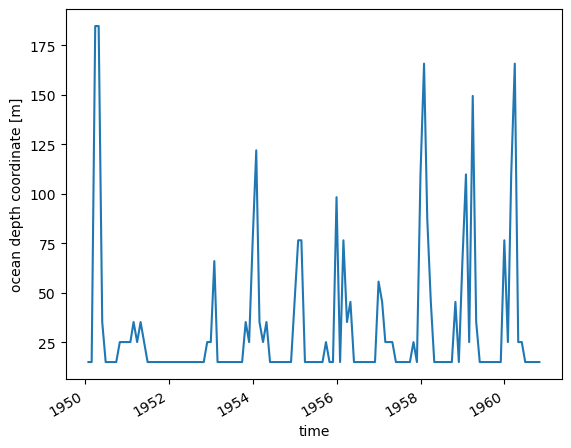

In [38]:
# Here we compute MLD from monthly density fields

def compute_mld2(rho):
    """To compute the mixed layer depth from density fields 
    Parameters
    ----------
    rho : xarray.DataArray for sigma0, dims must be time, space, depth (must be in metres)
    Returns
    -------
    mld: xarray.DataArray, dims of time, space
    
      ll
      
    """
    mld=rho
    

    # Here we identify the last level before 10m
    slevs=rho.lev
    ilev0=0


    for ilev in range(len(slevs)):   
     tlev = slevs[ilev]
     if tlev<= 10.: slev10=ilev
    

    # And we take the last level before 10m  as our sigma0 surface reference
    surf_dens = rho[:,slev10]

    
    

    # We compute the density difference between surface and whole field
    dens_diff = rho-surf_dens
        
    print(surf_dens.values)
    print(dens_diff.values)
    # keep density differences exceeding threshold, discard other values
    dens_diff = dens_diff.where(dens_diff > 0.03)   ### The threshold should be 0.03!!

    # We determine the level at which the threshold is exceeded by the minimum margin
    cutoff_lev=dens_diff.lev.where(dens_diff==dens_diff.min(["lev"])).max(["lev"])        
    mld=cutoff_lev.rename("mld")

    
    # compute water depth
    # note: pressure.lev, cthetao.lev, and abs_salinity.lev are identical
#    test = sigma0.isel(time=0) + sigma0.lev
#    bottom_depth = (
#        pressure.lev.where(test == test.max(dim="lev"))
#        .max(dim="lev")
#        .rename("bottom_depth")
#    )  # units 'meters'

    # set MLD to water depth where MLD is NaN
#    mld = mld.where(~np.isnan(mld), bottom_depth)

    return mld
mld_tm=compute_mld2(rho_t_s_labrador_en4_ml.rho[0:130,])
#rho_t_s_labrador_en4_ml.rho[0:6,].plot()
#print(rho_t_s_labrador_en4_ml.rho[0:6,])
mld_tm.plot()#mld_tm=fn.compute_mld(dmod_yearly_ls_mean)
